# Can we predict who would've survived the Titanic?

## This notebook goes through a basic exploratory data analysis (EDA) of the Kaggle Titanic dataset with Python

Although this notebook works towards creating a Kaggle submission, it should not be taken as exhaustive list of things to do with a dataset. It has been setup as an introduction to get you started with exploratory data analysis (EDA).

There are challenges and extensions listed throughout. I encourage you to take the foundations here and build upon them.

![titanic](https://unsplash.com/photos/g47YSnlebC8)


##Why EDA?


Not all data comes in a neat little package ready to be modelled by the latest and greatest machine learning models.

Most of the time, you'll get a dataset you don't know much about. So before you can make any solid predictions, you'll to find out more.

This is where EDA comes in.

The main thing to remember is the first word. Exploratory. You're trying to figure out more about the data so you can build a model the best way you can.

You'll usually do this when you first look at a dataset but it'll continually happen as you learn more. EDA is an iterative process. There's no one way to do it either. It'll vary with each new dataset but there are some things you'll find yourself doing more often, we'll talk about those in this notebook.

![](dylan-mcleod-728136-unsplash.jpg)


In [0]:
# access kaggle datasets
!pip install kaggle

# math operations
!pip install numpy==1.15.0

# machine learning
!pip install catboost

In [0]:
# import dependencies
%matplotlib inline

# start Python imports
import math, time, random, datetime

# data manipulation
import numpy as np
import pandas as pd

# visualization 
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# machine learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv

# let's ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

In [0]:
# Colab's file access feature
from google.colab import files

# retrieve uploaded file
uploaded = files.upload()

# print results
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 62 bytes


In [0]:
# download titanic dataset
!kaggle competitions download -c titanic

train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


### Loading in the data

After we've downloaded the data, we need to get it into the notebook.

In [0]:
# import train & test data 
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
gender_submission = pd.read_csv('gender_submission.csv') # example of what a submission should look like

In [0]:
# view the training data
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [0]:
# view the test data (same columns as the training data)
test.head() 

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S

In [0]:
# view the example submisison dataframe
gender_submission.head()

PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         1

## Data Descriptions

**Survival:** 0 = No, 1 = Yes

**pclass (Ticket class):** 1 = 1st, 2 = 2nd, 3 = 3rd

**sex:** Sex

**Age:** Age in years

**sibsp:** number of siblings/spouses aboard the Titanic

**parch:** number of parents/children aboard the Titanic

**ticket:** Ticket number

**fare:** Passenger fare

**cabin:** Cabin number

**embarked:** Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton

In [0]:
train.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

## What missing values are there?

Where are the holes in our data?

These are rows which are missing a value or have NaN instead of something like the rest of the column.

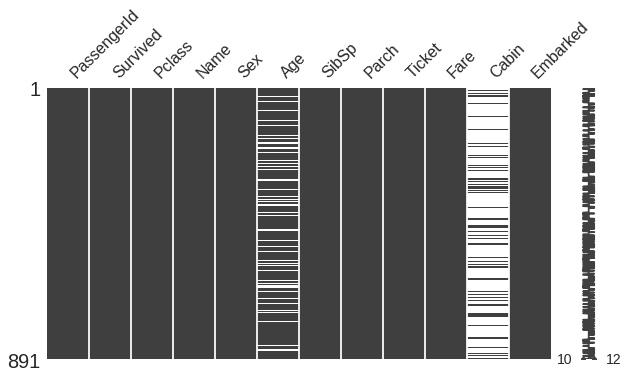

In [0]:
# plot graphic of missing values
missingno.matrix(train, figsize = (10,5))

Ok we can clearly see some missing values here. Especially in the cabin column.

It's important to visualise missing values early so you know where the major holes are in your dataset.

Knowing this informaiton will help with your EDA and figuring out what kind of data cleaning and preprocessing is needed.

In [0]:
# let's write a function to show us how many missing values there are
def find_missing_values(df, columns):
    """
    Finds number of rows where certain columns are missing values.
    ::param_df:: = target dataframe
    ::param_columns:: = list of columns
    """
    missing_vals = {}
    print("Number of missing or NaN values for each column:")
    df_length = len(df)
    for column in columns:
        total_column_values = df[column].value_counts().sum()
        missing_vals[column] = df_length-total_column_values
        #missing_vals.append(str(column)+ " column has {} missing or NaN values.".format())
    return missing_vals

missing_values = find_missing_values(train, columns=train.columns)
missing_values

Number of missing or NaN values for each column:


{'Age': 177,
 'Cabin': 687,
 'Embarked': 2,
 'Fare': 0,
 'Name': 0,
 'Parch': 0,
 'PassengerId': 0,
 'Pclass': 0,
 'Sex': 0,
 'SibSp': 0,
 'Survived': 0,
 'Ticket': 0}

## To perform our data analysis, let's create two new dataframes

We'll create one for exploring discretised continuous variables (continuous variables which have been sorted into some kind of category) and another for exploring continuous variables.

In [0]:
df_bin = pd.DataFrame() # for discretised continuous variables
df_con = pd.DataFrame() # for continuous variables

## What datatypes are in the dataframe?

As a general rule of thumb, features with a datatype of object could be considered categorical features. And those which are floats or ints (numbers) could be considered numerical features.

However, as we dig deeper, we might find features which are numerical may actually be categorical.

The goal for the next few steps is to figure out how best to process the data so our machine learning model can learn from it.

Ideally, all the features will be encoded into a numerical value of some kind. 

In [0]:
# different data types in the dataset
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## Let's explore each of these features individually
We'll go through each column iteratively and see which ones to use in our first models.
Some may need more preprocessing than others to get ready.

In [0]:
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

### Target Feature: Survived

Description: Whether the passenger survived or not.
    
Key: 0 = did not survive, 1 = survived
    
This is the variable we want our machine learning model to predict based off all the others.

0    549
1    342
Name: Survived, dtype: int64


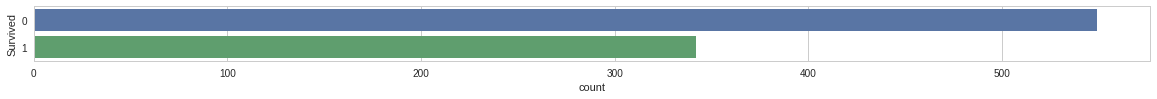

In [0]:
# how many people survived?
fig = plt.figure(figsize=(20,1))
sns.countplot(y='Survived', data=train)
print(train.Survived.value_counts())

In [0]:
# let's add this to our subset dataframes
df_bin['Survived'] = train['Survived']
df_con['Survived'] = train['Survived']

In [0]:
df_bin.head()

Survived
0         0
1         1
2         1
3         1
4         0

In [0]:
df_con.head()

Survived
0         0
1         1
2         1
3         1
4         0

### Feature: Pclass

Description: The ticket class of the passenger.
    
Key: 1 = 1st, 2 = 2nd, 3 = 3rd

#### Let's plot the distribution
We will look at the distribution of each feature first if we can to understand what kind of spread there is across the dataset.

For example, if there are values which are completely outside of the distribution, we may not want to include them in our model.

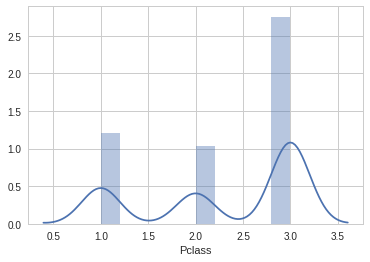

In [0]:
sns.distplot(train.Pclass)

We can see with this feature, the values are numerical (1, 2 and 3) but they are categories.

How do we know this? Because a passenger in Class 3 doesn't necessarily equal a passenger in Class 2 + a passenger in Class 1.

In [0]:
# how many missing variables does Pclass have?
missing_values['Pclass']

0

Since there are no missing values in Pclass, let's add it to our sub dataframes.

In [0]:
df_bin['Pclass'] = train['Pclass']
df_con['Pclass'] = train['Pclass']

### Feature: Name
    
Description: The name of the passenger.

In [0]:
# how many different names are there?
train.Name.value_counts()

Bradley, Mr. George ("George Arthur Brayton")         1
Chapman, Mr. Charles Henry                            1
Hays, Mrs. Charles Melville (Clara Jennings Gregg)    1
Daly, Mr. Peter Denis                                 1
Duff Gordon, Sir. Cosmo Edmund ("Mr Morgan")          1
Kalvik, Mr. Johannes Halvorsen                        1
Gale, Mr. Shadrach                                    1
Navratil, Master. Edmond Roger                        1
Bowerman, Miss. Elsie Edith                           1
Sinkkonen, Miss. Anna                                 1
Elsbury, Mr. William James                            1
Moor, Master. Meier                                   1
Meyer, Mr. August                                     1
Harrison, Mr. William                                 1
Zabour, Miss. Hileni                                  1
Brown, Mrs. James Joseph (Margaret Tobin)             1
Harris, Mrs. Henry Birkhardt (Irene Wallach)          1
Eitemiller, Mr. George Floyd                    

In [0]:
len(train)

891

Every row has a unique name. This is equivalent to the passenger ID. But name could be used differently.

Can you think of ways you could reduce the number of different names? Or create new features out of the names?

**Note:** Because of so many different names and to keep this EDA fast, we won't move forward using the name variable.

### Feature: Sex

Description: The sex of the passenger (male or female).

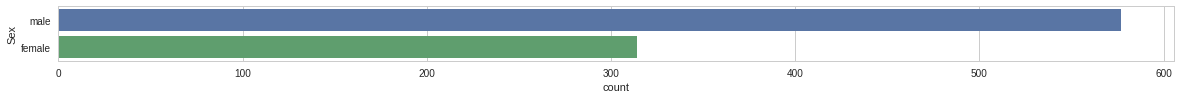

In [0]:
# let's view the distribution of Sex
plt.figure(figsize=(20, 1))
sns.countplot(y="Sex", data=train);

In [0]:
# are there any missing values in the Sex column?
missing_values['Sex']

0

Since this is already binary variable (male or female), let's add it straight to our subset dataframes.

In [0]:
train.Sex.head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: object

In [0]:
# add Sex to the subset dataframes
df_bin['Sex'] = train['Sex']
df_bin['Sex'] = np.where(df_bin['Sex'] == 'female', 0, 1) # change sex to 0 for male and 1 for female

df_con['Sex'] = train['Sex']

In [0]:
df_bin.head()

Survived  Pclass  Sex
0         0       3    1
1         1       1    0
2         1       3    0
3         1       1    0
4         0       3    1

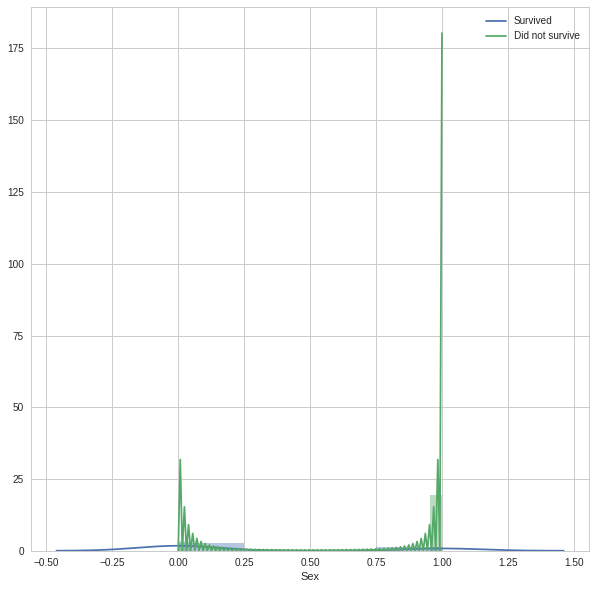

In [0]:
# how does the Sex variable look compared to Survival?
# we can see this because they're both binarys. binary is 1's & 0's
fig = plt.figure(figsize=(10, 10))
sns.distplot(df_bin.loc[df_bin['Survived'] == 1]['Sex'], kde_kws={'label': 'Survived'});
sns.distplot(df_bin.loc[df_bin['Survived'] == 0]['Sex'], kde_kws={'label': 'Did not survive'});

Not many people survived. But of those who did, more were female.

### Feature: Age

Description: The age of the passenger.

In [0]:
# how many missing values does age have?
missing_values['Age']

177

Out of a total 891 rows, that's almost one quarter of the dataset.

What would you do with these missing values?

Could replace them with the average age? What's the pro's and con's of doing this?

Or would you get rid of them completely?

We won't answer these questions in our initial EDA but this is something we would definitely revisit at a later date.


In [0]:
# once the Age values have been fixed up, we can add them to our sub dataframes.
# df_bin['Age'] = pd.cut(train['Age'], 10) # bucketed/binned into different categories
# df_con['Age'] = train['Age'] # non-bucketed

**Challenge:** How would you fill the missing variables in the `Age` column?

#### Function to create count and distribution visualisations

In [0]:
def plot_count_dist(data, bin_df, label_column, target_column, figsize=(20, 5), use_bin_df=False):
    """
    Function to plot counts and distributions of a label variable and 
    target variable side by side.
    ::param_data:: = target dataframe
    ::param_bin_df:: = binned dataframe for countplot
    ::param_label_column:: = binary labelled column
    ::param_target_column:: = column you want to view counts and distributions
    ::param_figsize:: = size of figure (width, height)
    ::param_use_bin_df:: = whether or not to use the bin_df, default False
    """
    if use_bin_df: 
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=bin_df);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive"});
    else:
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=data);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive"});

### Feature: SibSp

Description: The number of siblings/spouses the passenger has aboard the Titanic.

In [0]:
# how many missing values does SibSp have?
missing_values['SibSp']

0

In [0]:
# what values are there?
train.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

Let's add SibSp to our subset dataframes and view the distributions.

In [0]:
# add SibSp to subset dataframes
df_bin['SibSp'] = train['SibSp']
df_con['SibSp'] = train['SibSp']

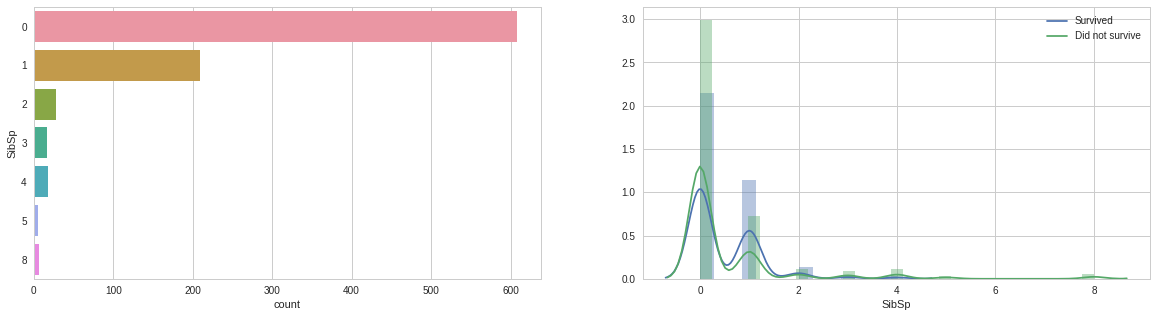

In [0]:
# visualise the counts of SibSp and the distribution of the values against Survived
plot_count_dist(train, 
                bin_df=df_bin, 
                label_column='Survived', 
                target_column='SibSp', 
                figsize=(20, 5))

What does the graph on the right tell us?

### Feature: Parch

Description: The number of parents/children the passenger has aboard the Titanic.

Since this feature is similar to SibSp, we'll do a similar analysis.

In [0]:
# how many missing values does SibSp have?
missing_values['Parch']

0

In [0]:
# what values are there?
train.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [0]:
# add Parch to subset dataframes
df_bin['Parch'] = train['Parch']
df_con['Parch'] = train['Parch']

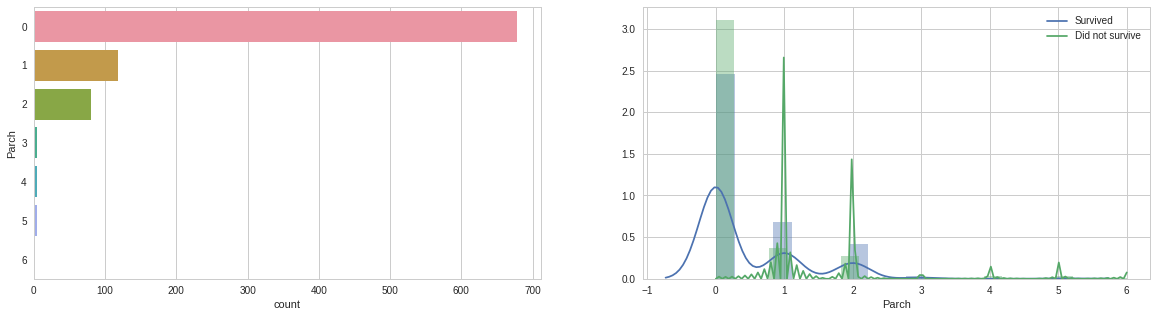

In [0]:
# visualise the counts of Parch and the distribution of the values against Survived
plot_count_dist(train, 
                bin_df=df_bin,
                label_column='Survived', 
                target_column='Parch', 
                figsize=(20, 5))

What does the graph on the right tell us about `Parch`?

In [0]:
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [0]:
df_con.head()

Survived  Pclass     Sex  SibSp  Parch
0         0       3    male      1      0
1         1       1  female      1      0
2         1       3  female      0      0
3         1       1  female      1      0
4         0       3    male      0      0

### Feature: Ticket

Description: The ticket number of the boarding passenger.

In [0]:
# how many missing values does Ticket have?
missing_values['Ticket']

0

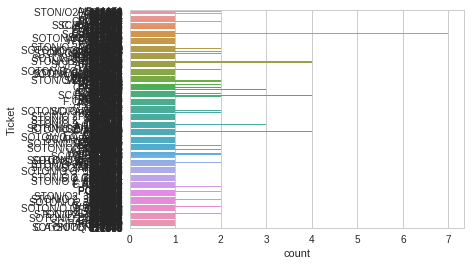

In [0]:
# how many kinds of ticket are there?
sns.countplot(y="Ticket", data=train);

That doesn't look too good, what about another way of looking at it?

In [0]:
# how many kinds of ticket are there?
train.Ticket.value_counts()

347082               7
1601                 7
CA. 2343             7
347088               6
3101295              6
CA 2144              6
382652               5
S.O.C. 14879         5
349909               4
17421                4
113760               4
PC 17757             4
347077               4
19950                4
113781               4
W./C. 6608           4
2666                 4
4133                 4
LINE                 4
347742               3
PC 17755             3
24160                3
248727               3
13502                3
110152               3
371110               3
230080               3
SC/Paris 2123        3
363291               3
345773               3
                    ..
36864                1
W./C. 14263          1
347085               1
315151               1
330932               1
3101265              1
8475                 1
349251               1
113028               1
2671                 1
A.5. 11206           1
347067               1
113056     

In [0]:
# how many unique kinds of Ticket are there?
print("There are {} unique Ticket values.".format(len(train.Ticket.unique())))

There are 681 unique Ticket values.


681 unique values is too many for now. So we won't use `Ticket` in our subset dataframes.

There may be some way to reduce this down. 

**Challenge:** How could you reduce the Ticket feature? Is it even possible?

*Hint:* It may be similar to what you could do with Name.

### Feature: Fare

Description: How much the ticket cost.

In [0]:
# how many missing values does Fare have?
missing_values['Fare']

0

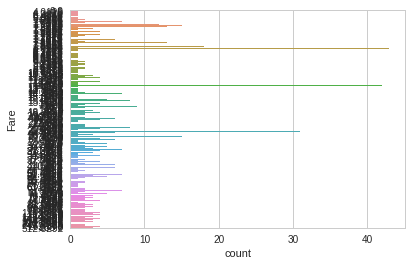

In [0]:
# how many different values of Fare are there?
sns.countplot(y="Fare", data=train);

In [0]:
# what kind of variable is Fare?
train.Fare.dtype

dtype('float64')

In [0]:
# how many unique kinds of Fare are there?
print("There are {} unique Fare values.".format(len(train.Fare.unique())))

There are 248 unique Fare values.


Because Fare is a float (number) let's add it as it is to our continuous sub dataframe but to add it to our categorical sub dataframe, we'll cut it into bins.

In [0]:
# add Fare to sub dataframes
df_con['Fare'] = train['Fare'] 
df_bin['Fare'] = pd.cut(train['Fare'], bins=5) # discretised 

In [0]:
# what do our Fare bins look like?
df_bin.Fare.value_counts()

(-0.512, 102.466]     838
(102.466, 204.932]     33
(204.932, 307.398]     17
(409.863, 512.329]      3
(307.398, 409.863]      0
Name: Fare, dtype: int64

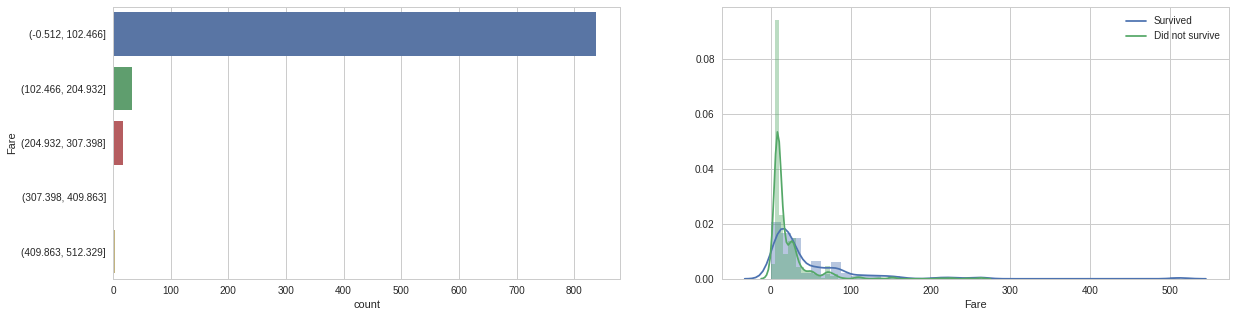

In [0]:
# visualise the Fare bin counts as well as the Fare distribution versus Survived.
plot_count_dist(data=train,
                bin_df=df_bin,
                label_column='Survived', 
                target_column='Fare', 
                figsize=(20,5), 
                use_bin_df=True)

**Challenge:** How would you change the Fare bins?

### Feature: Cabin

Description: The cabin number where the passenger was staying.    

In [0]:
# how many missing values does Cabin have?
missing_values['Cabin']

687

In [0]:
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [0]:
# what do the Cabin values look like?
train.Cabin.value_counts()

C23 C25 C27        4
B96 B98            4
G6                 4
F2                 3
D                  3
C22 C26            3
F33                3
E101               3
B18                2
F G73              2
C126               2
B35                2
E33                2
C93                2
D36                2
C92                2
D17                2
B51 B53 B55        2
E25                2
E44                2
C52                2
B22                2
B58 B60            2
C83                2
B57 B59 B63 B66    2
B28                2
C2                 2
C65                2
B77                2
C125               2
                  ..
B50                1
B82 B84            1
C32                1
C106               1
C70                1
A36                1
D47                1
B39                1
E17                1
C95                1
A14                1
B94                1
C101               1
B4                 1
D48                1
B79                1
C103         

Since there are too many missing values, we won't use Cabin for our initial models and won't add it to our sub dataframes.

But how could you modify cabin to be more usable?

What could you do about the missing values?

### Feature: Embarked

Description: The port where the passenger boarded the Titanic.
    
Key: C = Cherbourg, Q = Queenstown, S = Southampton

In [0]:
# how many missing values does Embarked have?
missing_values['Embarked']

2

In [0]:
# what kind of values are in Embarked?
train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Embarked is a categorical variable because there are 3 categories which a passenger could have boarded on.

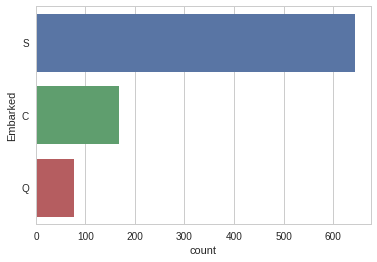

In [0]:
# what do the counts look like?
sns.countplot(y='Embarked', data=train);

#### How can we deal with the 2 missing values of Embarked?

One option is to drop the two rows which don't have an Embarked value.

Another option would be to randomly assign a value of C, Q or S to each row.

What are the pros and cons of each?

For now, we will remove those rows.

In [0]:
# add Embarked to sub dataframes
df_bin['Embarked'] = train['Embarked']
df_con['Embarked'] = train['Embarked']

In [0]:
# remove Embarked rows which are missing values
print(len(df_con))
df_con = df_con.dropna(subset=['Embarked'])
df_bin = df_bin.dropna(subset=['Embarked'])
print(len(df_con))

891
889


We've removed the two rows with missing values for Embarked, now we can add Embarked to our sub dataframes.

In [0]:
df_bin.head()

Survived  Pclass  Sex  SibSp  Parch               Fare Embarked
0         0       3    1      1      0  (-0.512, 102.466]        S
1         1       1    0      1      0  (-0.512, 102.466]        C
2         1       3    0      0      0  (-0.512, 102.466]        S
3         1       1    0      1      0  (-0.512, 102.466]        S
4         0       3    1      0      0  (-0.512, 102.466]        S

In [0]:
df_con.head()

Survived  Pclass     Sex  SibSp  Parch     Fare Embarked
0         0       3    male      1      0   7.2500        S
1         1       1  female      1      0  71.2833        C
2         1       3  female      0      0   7.9250        S
3         1       1  female      1      0  53.1000        S
4         0       3    male      0      0   8.0500        S

## Feature Encoding
Now we have our two sub dataframes ready. We can encode the features so they're ready to be used with our machine learning models.

We will encode our binned dataframe (`df_bin`) with one-hot encoding and our continuous dataframe (`df_con`) with the label encoding function from `sklearn`.

In [0]:
df_bin.head()

Survived  Pclass  Sex  SibSp  Parch               Fare Embarked
0         0       3    1      1      0  (-0.512, 102.466]        S
1         1       1    0      1      0  (-0.512, 102.466]        C
2         1       3    0      0      0  (-0.512, 102.466]        S
3         1       1    0      1      0  (-0.512, 102.466]        S
4         0       3    1      0      0  (-0.512, 102.466]        S

In [0]:
# one-hot encode binned variables i.e creating new df by assigning 1 to what it is and 0 to what it is'nt
one_hot_cols = df_bin.columns.tolist()
one_hot_cols.remove('Survived')
df_bin_enc = pd.get_dummies(df_bin, columns=one_hot_cols)

df_bin_enc.head()

Survived  Pclass_1  Pclass_2  Pclass_3  Sex_0  Sex_1  SibSp_0  SibSp_1  \
0         0         0         0         1      0      1        0        1   
1         1         1         0         0      1      0        0        1   
2         1         0         0         1      1      0        1        0   
3         1         1         0         0      1      0        0        1   
4         0         0         0         1      0      1        1        0   

   SibSp_2  SibSp_3     ...      Parch_5  Parch_6  Fare_(-0.512, 102.466]  \
0        0        0     ...            0        0                       1   
1        0        0     ...            0        0                       1   
2        0        0     ...            0        0                       1   
3        0        0     ...            0        0                       1   
4        0        0     ...            0        0                       1   

   Fare_(102.466, 204.932]  Fare_(204.932, 307.398]  Fare_(307.398, 409.863]  \
0                        0                        0                        0   
1                        0                        0                        0   
2                        0                        0                        0   
3                        0                        0                        0   
4                        0                        0                        0   

   Fare_(409.863, 512.329]  Embarked_C  Embarked_Q  Embarked_S  
0                        0           0           0           1  
1                        0           1           0           0  
2                        0           0           0           1  
3                        0           0           0           1  
4                        0           0           0           1  

[5 rows x 28 columns]

In [0]:
df_con.head(10)

Survived  Pclass     Sex  SibSp  Parch     Fare Embarked
0         0       3    male      1      0   7.2500        S
1         1       1  female      1      0  71.2833        C
2         1       3  female      0      0   7.9250        S
3         1       1  female      1      0  53.1000        S
4         0       3    male      0      0   8.0500        S
5         0       3    male      0      0   8.4583        Q
6         0       1    male      0      0  51.8625        S
7         0       3    male      3      1  21.0750        S
8         1       3  female      0      2  11.1333        S
9         1       2  female      1      0  30.0708        C

In [0]:
# label Encode all continuous values using LabelEncoder()
df_con_enc = df_con.apply(LabelEncoder().fit_transform)

df_con_enc.head(20)

Survived  Pclass  Sex  SibSp  Parch  Fare  Embarked
0          0       2    1      1      0    18         2
1          1       0    0      1      0   207         0
2          1       2    0      0      0    41         2
3          1       0    0      1      0   189         2
4          0       2    1      0      0    43         2
5          0       2    1      0      0    51         1
6          0       0    1      0      0   186         2
7          0       2    1      3      1   124         2
8          1       2    0      0      2    74         2
9          1       1    0      1      0   154         0
10         1       2    0      1      1   110         2
11         1       0    0      0      0   143         2
12         0       2    1      0      0    43         2
13         0       2    1      1      5   158         2
14         0       2    0      0      0    36         2
15         1       1    0      0      0   108         2
16         0       2    1      4      1   151         1
17         1       1    1      0      0    85         2
18         0       2    0      1      0   113         2
19         1       2    0      0      0    16         0

## Start Building Machine Learning Models
Now our data has been manipulating and converted to numbers, we can run a series of different machine learning algorithms over it to find which yield the best results.

### Let's seperate the data

In [0]:
# seclect the dataframe we want to use first for predictions
selected_df = df_con_enc

In [0]:
selected_df.head()

Survived  Pclass  Sex  SibSp  Parch  Fare  Embarked
0         0       2    1      1      0    18         2
1         1       0    0      1      0   207         0
2         1       2    0      0      0    41         2
3         1       0    0      1      0   189         2
4         0       2    1      0      0    43         2

In [0]:
# split the dataframe into data and labels
X_train = selected_df.drop('Survived', axis=1) # data
y_train = selected_df.Survived # labels

In [0]:
# shape of the data (without labels)
X_train.shape

(889, 6)

In [0]:
# shape of the labels
y_train.shape

(889,)

### Define a function to fit machine learning algorithms
Since many of the algorithms we will use are from the sklearn library, they all take similar (practically the same) inputs and produce similar outputs.

To prevent writing code multiple times, we will functionise fitting the model and returning the accuracy scores.

In [0]:
# Function that runs the requested algorithm and returns the accuracy metrics
def fit_ml_algo(algo, X_train, y_train, cv):
    
    # One Pass
    model = algo.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2)
    
    # Cross Validation 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    # Cross-validation accuracy metric
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    return train_pred, acc, acc_cv

### Logistic Regression

In [0]:
# Logistic Regression
start_time = time.time()
train_pred_log, acc_log, acc_cv_log = fit_ml_algo(LogisticRegression(), 
                                                               X_train, 
                                                               y_train, 
                                                                    10)
log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 79.08
Accuracy CV 10-Fold: 78.52
Running Time: 0:00:01.832081


### K-Nearest Neighbours

In [0]:
# k-Nearest Neighbours
start_time = time.time()
train_pred_knn, acc_knn, acc_cv_knn = fit_ml_algo(KNeighborsClassifier(), 
                                                  X_train, 
                                                  y_train, 
                                                  10)
knn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy: 81.44
Accuracy CV 10-Fold: 73.68
Running Time: 0:00:00.059946


### Gaussian Naive Bayes

In [0]:
# Gaussian Naive Bayes
start_time = time.time()
train_pred_gaussian, acc_gaussian, acc_cv_gaussian = fit_ml_algo(GaussianNB(), 
                                                                      X_train, 
                                                                      y_train, 
                                                                           10)
gaussian_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Accuracy: 76.72
Accuracy CV 10-Fold: 76.38
Running Time: 0:00:00.051679


### Linear Support Vector Machines (SVC)

In [0]:
# Linear SVC
start_time = time.time()
train_pred_svc, acc_linear_svc, acc_cv_linear_svc = fit_ml_algo(LinearSVC(),
                                                                X_train, 
                                                                y_train, 
                                                                10)
linear_svc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)
print("Running Time: %s" % datetime.timedelta(seconds=linear_svc_time))

Accuracy: 76.72
Accuracy CV 10-Fold: 74.47
Running Time: 0:00:00.433471


### Stochastic Gradient Descent

In [0]:
# Stochastic Gradient Descent
start_time = time.time()
train_pred_sgd, acc_sgd, acc_cv_sgd = fit_ml_algo(SGDClassifier(), 
                                                  X_train, 
                                                  y_train,
                                                  10)
sgd_time = (time.time() - start_time)
print("Accuracy: %s" % acc_sgd)
print("Accuracy CV 10-Fold: %s" % acc_cv_sgd)
print("Running Time: %s" % datetime.timedelta(seconds=sgd_time))

Accuracy: 60.74
Accuracy CV 10-Fold: 57.14
Running Time: 0:00:00.054398


### Decision Tree Classifier

In [0]:
# Decision Tree Classifier
start_time = time.time()
train_pred_dt, acc_dt, acc_cv_dt = fit_ml_algo(DecisionTreeClassifier(), 
                                                                X_train, 
                                                                y_train,
                                                                10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 92.46
Accuracy CV 10-Fold: 79.64
Running Time: 0:00:00.066122


### Gradient Boost Trees

In [0]:
# Gradient Boosting Trees
start_time = time.time()
train_pred_gbt, acc_gbt, acc_cv_gbt = fit_ml_algo(GradientBoostingClassifier(), 
                                                                       X_train, 
                                                                       y_train,
                                                                       10)
gbt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))

Accuracy: 86.39
Accuracy CV 10-Fold: 81.1
Running Time: 0:00:00.781932


### CatBoost Algorithm
CatBoost is a state-of-the-art open-source gradient boosting on decision trees library.

It's simple and easy to use. And is now regularly one of my go-to algorithms for any kind of machine learning task.

For more on CatBoost and the methods it uses to deal with categorical variables, check out the [CatBoost docs](https://catboost.ai/).

In [0]:
# view the data for the CatBoost model
X_train.head()

Pclass  Sex  SibSp  Parch  Fare  Embarked
0       2    1      1      0    18         2
1       0    0      1      0   207         0
2       2    0      0      0    41         2
3       0    0      1      0   189         2
4       2    1      0      0    43         2

In [0]:
# view the labels for the CatBoost model
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [0]:
# define the categorical features for the CatBoost model
cat_features = np.where(X_train.dtypes != np.float)[0]
cat_features

array([0, 1, 2, 3, 4, 5])

This means Catboost has picked up that all variables except `Fare` can be treated as categorical.

In [0]:
# use the CatBoost Pool() function to pool together the training data and categorical feature labels
train_pool = Pool(X_train, 
                  y_train,
                  cat_features)

In [0]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [0]:
# CatBoost model definition
catboost_model = CatBoostClassifier(iterations=1000,
                                    custom_loss=['Accuracy'],
                                    loss_function='Logloss')

# Fit CatBoost model
catboost_model.fit(train_pool,
                   plot=True)

# CatBoost accuracy
acc_catboost = round(catboost_model.score(X_train, y_train) * 100, 2)

Learning rate set to 0.016206


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6838699	total: 42.1ms	remaining: 42.1s
1:	learn: 0.6753070	total: 90.8ms	remaining: 45.3s
2:	learn: 0.6664907	total: 146ms	remaining: 48.5s
3:	learn: 0.6580711	total: 176ms	remaining: 43.9s


4:	learn: 0.6509880	total: 212ms	remaining: 42.2s
5:	learn: 0.6430105	total: 226ms	remaining: 37.5s
6:	learn: 0.6363867	total: 236ms	remaining: 33.5s
7:	learn: 0.6298197	total: 249ms	remaining: 30.9s
8:	learn: 0.6229042	total: 266ms	remaining: 29.3s
9:	learn: 0.6164721	total: 278ms	remaining: 27.5s
10:	learn: 0.6090541	total: 298ms	remaining: 26.8s
11:	learn: 0.6031504	total: 312ms	remaining: 25.7s
12:	learn: 0.5977758	total: 322ms	remaining: 24.5s
13:	learn: 0.5920107	total: 340ms	remaining: 24s
14:	learn: 0.5865860	total: 355ms	remaining: 23.3s
15:	learn: 0.5815069	total: 367ms	remaining: 22.5s
16:	learn: 0.5766008	total: 375ms	remaining: 21.7s
17:	learn: 0.5734912	total: 383ms	remaining: 20.9s
18:	learn: 0.5683202	total: 394ms	remaining: 20.3s
19:	learn: 0.5638584	total: 411ms	remaining: 20.1s
20:	learn: 0.5592792	total: 425ms	remaining: 19.8s
21:	learn: 0.5544849	total: 443ms	remaining: 19.7s
22:	learn: 0.5505635	total: 463ms	remaining: 19.6s
23:	learn: 0.5470343	total: 472ms	remai

In [0]:
# Perform CatBoost cross-validation
start_time = time.time()

# Set params for cross-validation as same as initial model
cv_params = catboost_model.get_params()

# Run the cross-validation for 10-folds (same as the other models)
cv_data = cv(train_pool,
             cv_params,
             fold_count=10,
             plot=True)

# How long did it take?
catboost_time = (time.time() - start_time)

# CatBoost CV results save into a dataframe (cv_data), let's withdraw the maximum accuracy score
acc_cv_catboost = round(np.max(cv_data['test-Accuracy-mean']) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6841256	test: 0.6840888	best: 0.6840888 (0)
1:	learn: 0.6755854	test: 0.6759349	best: 0.6759349 (1)
2:	learn: 0.6673580	test: 0.6678242	best: 0.6678242 (2)
3:	learn: 0.6593220	test: 0.6598724	best: 0.6598724 (3)
4:	learn: 0.6516587	test: 0.6521665	best: 0.6521665 (4)	total: 1.16s	remaining: 3m 49s
5:	learn: 0.6443556	test: 0.6451184	best: 0.6451184 (5)
6:	learn: 0.6376641	test: 0.6384372	best: 0.6384372 (6)
7:	learn: 0.6312767	test: 0.6317963	best: 0.6317963 (7)
8:	learn: 0.6247155	test: 0.6253194	best: 0.6253194 (8)
9:	learn: 0.6185368	test: 0.6193121	best: 0.6193121 (9)
10:	learn: 0.6125186	test: 0.6132487	best: 0.6132487 (10)
11:	learn: 0.6068958	test: 0.6078234	best: 0.6078234 (11)
12:	learn: 0.6016277	test: 0.6027394	best: 0.6027394 (12)
13:	learn: 0.5960680	test: 0.5972147	best: 0.5972147 (13)
14:	learn: 0.5909693	test: 0.5920910	best: 0.5920910 (14)
15:	learn: 0.5857014	test: 0.5870332	best: 0.5870332 (15)
16:	learn: 0.5808991	test: 0.5822727	best: 0.5822727 (16)
17:

In [0]:
# print out the CatBoost model metrics
print("---CatBoost Metrics---")
print("Accuracy: {}".format(acc_catboost))
print("Accuracy CV 10-Fold: {}".format(acc_cv_catboost))
print("Running Time: {}".format(datetime.timedelta(seconds=catboost_time)))

---CatBoost Metrics---
Accuracy: 87.63
Accuracy CV 10-Fold: 81.66
Running Time: 0:02:59.807357


## Model Results
Which model had the best cross-validation accuracy?

**Note:** We care most about cross-validation metrics because the metrics we get from `.fit()` can randomly score higher than usual.

### Regular accuracy scores

In [0]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_knn, 
        acc_log,  
        acc_gaussian, 
        acc_sgd, 
        acc_linear_svc, 
        acc_dt,
        acc_gbt,
        acc_catboost
    ]})
print("---Reuglar Accuracy Scores---")
models.sort_values(by='Score', ascending=False)

---Reuglar Accuracy Scores---


Model  Score
5               Decision Tree  92.46
7                    CatBoost  87.63
6     Gradient Boosting Trees  86.39
0                         KNN  81.44
1         Logistic Regression  79.08
2                 Naive Bayes  76.72
4                  Linear SVC  76.72
3  Stochastic Gradient Decent  60.74

In [0]:
cv_models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_cv_knn, 
        acc_cv_log,      
        acc_cv_gaussian, 
        acc_cv_sgd, 
        acc_cv_linear_svc, 
        acc_cv_dt,
        acc_cv_gbt,
        acc_cv_catboost
    ]})
print('---Cross-validation Accuracy Scores---')
cv_models.sort_values(by='Score', ascending=False)

---Cross-validation Accuracy Scores---


Model  Score
7                    CatBoost  81.66
6     Gradient Boosting Trees  81.10
5               Decision Tree  79.64
1         Logistic Regression  78.52
2                 Naive Bayes  76.38
4                  Linear SVC  74.47
0                         KNN  73.68
3  Stochastic Gradient Decent  57.14

We can see from the tables, the CatBoost model had the best results. Getting just under **82%** is pretty good considering guessing would result in about 50% accuracy (0 or 1).

We'll pay more attention to the cross-validation figure.

Cross-validation is more robust than just the `.fit()` models as it does multiple passes over the data instead of one.

Because the CatBoost model got the best results, we'll use it for the next steps.

**Challenge:** How could you improve the CatBoost model?

## Feature Importance
Which features of the best model were most important for making predictions?

In [0]:
# Feature Importance
def feature_importance(model, data):
    """
    Function to show which features are most important in the model.
    ::param_model:: Which model to use?
    ::param_data:: What data to use?
    """
    fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': data.columns})
    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
    _ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 5))
    return fea_imp
    #plt.savefig('catboost_feature_importance.png') 

col        imp
2     SibSp   9.811795
5  Embarked  11.489122
4      Fare  12.736799
3     Parch  13.778596
0    Pclass  22.965584
1       Sex  29.218104

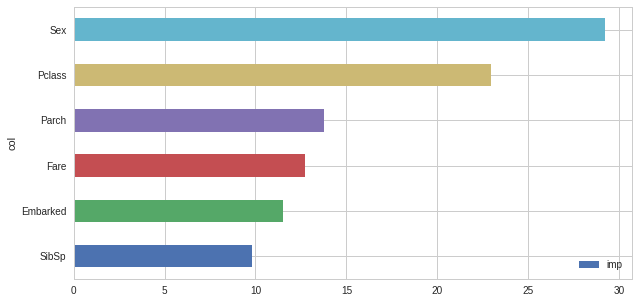

In [219]:
# plot the feature importance scores
feature_importance(catboost_model, X_train)

#### Why would you want feature importance?

Featrue importance shows how much each feature contributed to the model.

You could take this information and remove features which don't contribute much to reduce dimenstionality (and save compute).

You could improve features which don't offer much to the overall model.

Or you could improve features which offer more to the model. In this case, there aren't many ways you could improve sex as it's already a binary.

Feature importance figures also show people who may not be familiar with the problem what features of their data are most important when it comes to making predictions with machine learning models.

## Precision and Recall

Precision and recall are two metrics which are used for cases where you have have an imbalanced classification problem.

For example, you may have 100,000 people and only 1 of them gets a certain disease. If your model predicts that all people don't have the disease, it only misses 1 in 100,000 so its accuracy is 99.999%. But this isn't really helpful.

This is where precision an recall come in.

**Recall** = a metric which measures a models ability to find all the relevant cases in a dataset.

Recall would be the models ability to find the 1 person in 100,000 who has the disease.

**Precision** = a metric which measures a models ability to correctly identify only relevant instances.

In our example, Precision would be if the model found the 1 person who had the disease, did they actually have the disease.

Combining the precision and recall, gives an **F1 score.**

These metrics will all fall between 0 and 1, with a higher value being better.

Although, they don't necessarily need to come into play for our Titantic problem, they're worth remembering for your future work.

In [0]:
metrics = ['Precision', 'Recall', 'F1', 'AUC']

eval_metrics = catboost_model.eval_metrics(train_pool,
                                           metrics=metrics,
                                           plot=True)

for metric in metrics:
    print(str(metric)+": {}".format(np.mean(eval_metrics[metric])))

Precision: 0.8798765427169649
Recall: 0.7200647058823528
F1: 0.7912832504423744
AUC: 0.9059489713918354


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Recall is low, this means there's a higher amount of false negatives (predicting Did not survive when it was actually Survived).

Precision is higher therefore there's less false positives (predicting Survived, when it was actually Did not survive).

**Challenge:** What are some ways to visualise precision and recall? 
*Hint:* You may want to look into what a confusion matrix is, you can find much more information in this blog post: [Beyond Accuracy: Precision and Recall](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c)

## Submission
Let's use the model with the highest cross-validation accuracy score to make a prediction on the test dataset and then submit our predictions to Kaggle.

We want to make predictions on the same kind of columnns our model is trained on.

So we have to select the subset of right columns of the `test` dateframe, encode them and make a prediciton with our model.

In [0]:
# we need our test dataframe to look like this one
X_train.head()

Pclass  Sex  SibSp  Parch  Fare  Embarked
0       2    1      1      0    18         2
1       0    0      1      0   207         0
2       2    0      0      0    41         2
3       0    0      1      0   189         2
4       2    1      0      0    43         2

In [0]:
# our test dataframe has some columns our model hasn't been trained on
test.head()

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S

In [0]:
# create a list of columns to be used for the predictions
wanted_test_columns = X_train.columns
wanted_test_columns

Index(['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')

In [0]:
# make a prediction using the CatBoost model on the wanted columns
predictions = catboost_model.predict(test[wanted_test_columns]
                                     .apply(LabelEncoder().fit_transform))

In [0]:
# our predictions array is comprised of 0's and 1's (Survived or Did Not Survive)
predictions[:20]

array([0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 1., 1.])

In [0]:
# create a submisison dataframe and append the relevant columns
submission = pd.DataFrame()
submission['PassengerId'] = test['PassengerId']
submission['Survived'] = predictions # our model predictions on the test dataset
submission.head()

PassengerId  Survived
0          892       0.0
1          893       0.0
2          894       0.0
3          895       0.0
4          896       0.0

In [0]:
# what does our submission have to look like?
gender_submission.head()

PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         1

We need our `submission` dataframe to look like the `gender_submisison` dataframe, so we'll turn the `Survived` column into integers.

In [0]:
# let's convert our submission dataframe 'Survived' column to ints
submission['Survived'] = submission['Survived'].astype(int)
print('Converted Survived column to integers.')

Converted Survived column to integers.


In [0]:
# how does our submission dataframe look?
submission.head()

PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0

In [0]:
# are our test and submission dataframes the same length?
if len(submission) == len(test):
    print("Submission dataframe is the same length as test ({} rows).".format(len(submission)))
else:
    print("Dataframes mismatched, won't be able to submit to Kaggle.")

Submission dataframe is the same length as test (418 rows).


In [0]:
# convert submisison dataframe to csv for submission to csv for Kaggle submisison
submission.to_csv('../catboost_submission.csv', index=False)
print('Submission CSV is ready!')

Submission CSV is ready!


In [0]:
# check the submission csv to make sure it's in the right format
submissions_check = pd.read_csv("../catboost_submission.csv")
submissions_check.head()

PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0

### Now submit your .csv to Kaggle! 

https://www.kaggle.com/c/titanic/submit

## Possible Extensions

These are all possible options to improve this pipeline. I'd suggest starting with the feature engineering (improving and manipulating the existing data) first.

* What can you do with the `Age` feature?
    * How would fill up all the missing values?
    * You may want to look into the `interpolate()` function of Pandas for this
<br>
<br>
2. What can you do with the `Name` feature?
    * What titles did the passengers have? Did this influence their survival?
<br>
<br>
3. What can you do with the `Cabin` feature?
    * Is there a way to see whether they had a cabin or not?
<br>
<br>
4. Can you combine the `SibSp` and `Parch` features to see if the person was alone or not?
<br>
<br>
5. Could you do a PCA/feature analysis to see what features are more important than others?
    * Does removing the less important model features improve the model?
<br>
<br>
7. The models take a bunch of hyperparameters but we've mostly used the default settings, is there a way to find which hyperparameters are best to use?
    * Tip: Check out the `CatBoost` with Python tutorial and the [hyperopt library](https://github.com/hyperopt/hyperopt) to see if you can improve the CatBoost model

    

## References and Learn More

* [Sklearn Classification Notebook by Daniel Furasso](https://github.com/dformoso/sklearn-classification/blob/master/Data%20Science%20Workbook%20-%20Census%20Income%20Dataset.ipynb) - Daniel has done some epic work showing how you can take a bigger dataset, clean it up and perform some similar classification work from scratch. It would be a great next step after going through this one.
<br>

* [Encoding categorical features in Python blog post by Practical Python Business](http://pbpython.com/categorical-encoding.html) - this blog post sheds some great light on how to deal with categorical features in Python. The rest of the website contains plenty more great information for using Python in a business environment.
<br>

* [CatBoost Python tutorial on GitHub](https://github.com/catboost/tutorials/blob/master/python_tutorial.ipynb) - the tutorial is based on the Titanic Dataset and has some great tricks to improve the results in this notebook.
<br>

* [Shap library](https://github.com/slundberg/shap) - a great (and beautiful) alternative to viewing feature importance. Can you use this to improve on the feature importance graphics?